# GreenValueNet

This notebook contains the code needed to execute the GreenValueNet hedonic pricing neural network. 

### Set up and data loading

In [1]:
import joblib
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from data_load_funcs import get_params, load_data_catalogue
from processing_funcs import process_data, normalise_arr
from model_funcs import *

cwd = Path.cwd()
params = get_params()
data_catalogue = load_data_catalogue()

The `dataset.csv` file from `data/interim_files` is loaded if it already exists, or constructed if not. To build the dataset please follow the steps in [Annex 1 of the ReadMe file](readme.md#annex-1) to esnure all relevant files have been downloaded. 

In [2]:
dataset = process_data(data_catalogue, params)

# show summary stats
summary_stats = dataset.describe().transpose()[['mean', 'std', 'max', 'min']]
summary_stats.columns = ['Mean', 'Std Dev', 'Maximum', 'Minimum']
print(summary_stats)

Processed dataset already exists.
Loading exisitng dataset...
                                  Mean    Std Dev       Maximum   Minimum
ln_price                     12.393713   0.658136     18.134158  0.116855
propertytype                  1.328094   1.085676      3.000000  0.000000
oldnew                        0.134435   0.341119      1.000000  0.000000
duration                      0.325202   0.468482      2.000000  0.000000
current_energy_efficiency    61.056443  12.444568    347.000000  0.000000
potential_energy_efficiency   0.805024   0.140106      1.000000  0.000000
total_floor_area             91.622326  68.669650  60506.700000  0.000000
extension_count               0.495053   0.743755      4.000000  0.000000
number_habitable_rooms        4.521529   1.748808    100.000000  0.000000
number_heated_rooms           4.437662   1.754007    100.000000  0.000000
construction_age_band         4.477500   3.153767     10.000000 -1.000000
coastline_dist               57.173176  38.518186 

In [3]:
print(dataset.shape)
print(dataset.isnull().sum())

(12909200, 26)
transactionid                  0
ln_price                       0
postcode                       0
propertytype                   0
oldnew                         0
duration                       0
current_energy_efficiency      0
potential_energy_efficiency    0
total_floor_area               0
extension_count                0
number_habitable_rooms         0
number_heated_rooms            0
construction_age_band          0
coastline_dist                 0
prim_school_dist               0
sec_school_dist                0
roads_dist                     0
nat_park_dist                  0
nat_trust_dist                 0
ttwa_dist                      0
dom_builds_share               0
garden_share                   0
non_dom_builds_share           0
path_share                     0
greenspace_share               0
water_share                    0
dtype: int64


Now we normalise any non-encoded variables to make the loss function more symmetrics, and therefore increase speed of learning of algorithm and convert the dataset to an array of inputs, and an associated output array.

In [4]:
# creates in input array of shape m,x and an output array of shape m
x, y, derivative_index, norm_index = create_x_y_arr(dataset, params)

x_norm, pop_mean, pop_std = normalise_arr(x, norm_index)

The dataset is then split into train, dev and test sets using sci-kit learn.

In [5]:
x_train, x_dev, x_test, y_train, y_dev, y_test = split_to_test_dev_train(
    x_norm,
    y,
    params['dev_size'],
    params['test_size'],
    prop=False
)

## Benchmarking

To evaluate the performance of my neural network we use random forest and XGBoost regressions as baseline models. We optimise based on the mean squared error (MSE) and report this as our measure of performance.

### Random Forest


In [6]:
# run baseline random forest regression using scikit-learn
rf_hp_space = params['tuning_dict']['rf_space']
rfr_model = baseline_model(
    x_train,
    y_train,
    RandomForestRegressor,
    tuning=False,
    tuning_params=rf_hp_space,
    tuning_iter=params['tuning_dict']['n_iter']
)

# generate predictions and measure according to mean squared error
rfr_pred, rfr_mse = generate_pred_metric(rfr_model, mean_squared_error, x_dev, y_dev)

### XGBoost

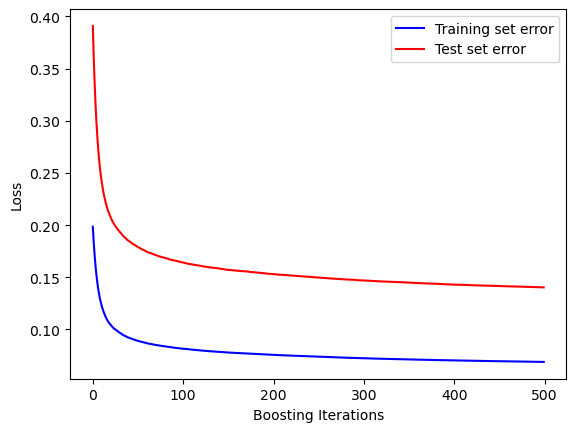

In [ ]:
# run baseline gradient boosting regression using scikit-learn
xg_hp_space = params['tuning_dict']['xg_space']
xgb_model = baseline_model(
    x_train,
    y_train,
    HistGradientBoostingRegressor,
    tuning=False,
    tuning_params=xg_hp_space,
    tuning_iter=params['tuning_dict']['n_iter'],
    max_iter = 500,
    max_depth = 18,
    learning_rate = 0.1,
    min_samples_leaf=50
)

# generate predictions and measure according to mean squared error
xgb_pred, xgb_mse = generate_pred_metric(xgb_model, mean_squared_error, x_dev, y_dev)

# plot loss over iterations
plot_loss(xgb_model, validation_data=(x_dev, y_dev), metric=mean_squared_error)

## Neural networks

We know build some neural networks. Number of epochs, hidden layers, and nodes in hidden layers is initially set with rules of thumb but then optimiszed using hyperparameter tuning.

In [6]:
# set epochs based on past convergence behaviour
epochs = 30

# set n_hidden_units to be mean of input and output layer sizes
n_hidden_units = round((x_train.shape[1] + 1) / 2)

### Single Layer Neural Network

A single hidden layer with ReLU activation is used with a linear output layer.

In [7]:
tune_nn = False
single_nn = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 1,
    tuning = tune_nn,
)
single_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
single_nn.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data = (x_dev, y_dev),
    callbacks=[get_checkpoint('single_nn')]
)

Epoch 1/30
402788/402788 [==============================] - 126s 311us/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.2334 - val_mse: 0.2334
Epoch 2/30
402788/402788 [==============================] - 124s 307us/step - loss: 0.2331 - mse: 0.2331 - val_loss: 0.2364 - val_mse: 0.2364
Epoch 3/30
402788/402788 [==============================] - 123s 306us/step - loss: 0.2332 - mse: 0.2332 - val_loss: 0.2301 - val_mse: 0.2301
Epoch 4/30
402788/402788 [==============================] - 123s 306us/step - loss: 0.2332 - mse: 0.2332 - val_loss: 0.2496 - val_mse: 0.2496
Epoch 5/30
402788/402788 [==============================] - 123s 306us/step - loss: 0.2331 - mse: 0.2331 - val_loss: 0.2368 - val_mse: 0.2368
Epoch 6/30
402788/402788 [==============================] - 124s 308us/step - loss: 0.2331 - mse: 0.2331 - val_loss: 0.2383 - val_mse: 0.2383
Epoch 7/30
402788/402788 [==============================] - 123s 306us/step - loss: 0.2332 - mse: 0.2332 - val_loss: 0.2264 - val_mse: 0.2264
Epoch 

### Deep Neural Network

The full model is specified as a deep neural network using layers with ReLU activation functions with a linear activation in the output layer. The choice of number of layers was initially kept small due to computational processing constraints.

In [22]:
tune_nn = False

deep_nn = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 10,
    tuning = tune_nn,
    learning_rate=0.1
)

deep_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 12)                288       
                                                                 
 dense_38 (Dense)            (None, 12)                156       
                                                                 
 dense_39 (Dense)            (None, 12)                156       
                                                                 
 dense_40 (Dense)            (None, 12)                156       
                                                                 
 dense_41 (Dense)            (None, 12)                156       
                                                                 
 dense_42 (Dense)            (None, 12)                156       
                                                                 
 dense_43 (Dense)            (None, 12)               

In [31]:
deep_nn.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_data = (x_dev, y_dev),
    callbacks=[get_checkpoint('deep_nn')]
)

Epoch 1/30
201394/201394 [==============================] - 111s 547us/step - loss: 0.1815 - mse: 0.1815 - val_loss: 0.1775 - val_mse: 0.1775
Epoch 2/30
201394/201394 [==============================] - 108s 536us/step - loss: 0.1810 - mse: 0.1810 - val_loss: 0.1835 - val_mse: 0.1835
Epoch 3/30
201394/201394 [==============================] - 107s 533us/step - loss: 0.1805 - mse: 0.1805 - val_loss: 0.1872 - val_mse: 0.1872
Epoch 4/30
201394/201394 [==============================] - 108s 535us/step - loss: 0.1802 - mse: 0.1802 - val_loss: 0.1765 - val_mse: 0.1765
Epoch 5/30
201394/201394 [==============================] - 108s 535us/step - loss: 0.1801 - mse: 0.1801 - val_loss: 0.1843 - val_mse: 0.1843
Epoch 6/30
201394/201394 [==============================] - 111s 554us/step - loss: 0.1800 - mse: 0.1800 - val_loss: 0.1761 - val_mse: 0.1761
Epoch 7/30
201394/201394 [==============================] - 109s 539us/step - loss: 0.1799 - mse: 0.1799 - val_loss: 0.1777 - val_mse: 0.1777
Epoch 

### Hyperparameter tuning

We know run the deep neural network but rather than setting the learning rate, hidden units and hidden layers ourself we let the model determine the optimal set of hyperparameters using Bayesian updating of the hyperparameters.

In [11]:
tune_nn = True

deep_nn_t = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 10,
    tuning = tune_nn,
    dropout=True,
    d_rate = 0.1
)

if tune_nn:
    tuner = run_hp_search(
        x_train,
        y_train,
        validation_set=(x_dev, y_dev),
        search_name='neural_net_240902'
    )
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(best_hps.values)
    deep_nn_t = tuner.hypermodel.build(best_hps)

deep_nn_t.summary()

Trial 20 Complete [00h 13m 18s]
mse: 0.15952980518341064

Best mse So Far: 0.13490168750286102
Total elapsed time: 04h 54m 03s


{'n_units': 96, 'n_layers': 12, 'lr': 0.001}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 96)                2304      
                                                                 
 dense_14 (Dense)            (None, 96)                9312      
                                                                 
 dense_15 (Dense)            (None, 96)                9312      
                                                                 
 dense_16 (Dense)            (None, 96)                9312      
                                                                 
 dense_17 (Dense)            (None, 96)                9312      
                                                                 
 dense_18 (Dense)            (None, 96)                9312      
                                                                 
 dense_19

In [12]:
if tune_nn:
    deep_nn_t.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=64,
        validation_data = (x_dev, y_dev),
        callbacks=[get_checkpoint('deep_nn_tuning')]
    )

Epoch 1/30
402788/402788 [==============================] - 495s 1ms/step - loss: 0.1629 - mse: 0.1629 - val_loss: 0.1380 - val_mse: 0.1380
Epoch 2/30
402788/402788 [==============================] - 455s 1ms/step - loss: 0.1374 - mse: 0.1374 - val_loss: 0.1361 - val_mse: 0.1361
Epoch 3/30
402788/402788 [==============================] - 462s 1ms/step - loss: 0.1341 - mse: 0.1341 - val_loss: 0.1323 - val_mse: 0.1323
Epoch 4/30
402788/402788 [==============================] - 466s 1ms/step - loss: 0.1326 - mse: 0.1326 - val_loss: 0.1299 - val_mse: 0.1299
Epoch 5/30
402788/402788 [==============================] - 466s 1ms/step - loss: 0.1321 - mse: 0.1321 - val_loss: 0.1307 - val_mse: 0.1307
Epoch 6/30
402788/402788 [==============================] - 466s 1ms/step - loss: 0.1298 - mse: 0.1298 - val_loss: 0.1283 - val_mse: 0.1283
Epoch 7/30
402788/402788 [==============================] - 467s 1ms/step - loss: 0.1290 - mse: 0.1290 - val_loss: 0.1276 - val_mse: 0.1276
Epoch 8/30
402788/40

In [34]:
tune_nn = False

deep_nn_t = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = 96,
    n_layers = 12,
    tuning = tune_nn,
    learning_rate=0.001
)

deep_nn_t.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 96)                2304      
                                                                 
 dense_62 (Dense)            (None, 96)                9312      
                                                                 
 dense_63 (Dense)            (None, 96)                9312      
                                                                 
 dense_64 (Dense)            (None, 96)                9312      
                                                                 
 dense_65 (Dense)            (None, 96)                9312      
                                                                 
 dense_66 (Dense)            (None, 96)                9312      
                                                                 
 dense_67 (Dense)            (None, 96)               

In [35]:
deep_nn_t.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_data = (x_dev, y_dev),
    callbacks=[get_checkpoint('deep_nn_tuning')]
)

Epoch 1/30
201394/201394 [==============================] - 294s 1ms/step - loss: 0.1701 - mse: 0.1701 - val_loss: 0.1490 - val_mse: 0.1490
Epoch 2/30
201394/201394 [==============================] - 300s 1ms/step - loss: 0.1374 - mse: 0.1374 - val_loss: 0.1359 - val_mse: 0.1359
Epoch 3/30
201394/201394 [==============================] - 298s 1ms/step - loss: 0.1335 - mse: 0.1335 - val_loss: 0.1305 - val_mse: 0.1305
Epoch 4/30
201394/201394 [==============================] - 299s 1ms/step - loss: 0.1305 - mse: 0.1305 - val_loss: 0.1310 - val_mse: 0.1310
Epoch 5/30
201394/201394 [==============================] - 264s 1ms/step - loss: 0.1290 - mse: 0.1290 - val_loss: 0.1286 - val_mse: 0.1286
Epoch 6/30
201394/201394 [==============================] - 260s 1ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 7/30
201394/201394 [==============================] - 262s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1292 - val_mse: 0.1292
Epoch 8/30
201394/20

## Results

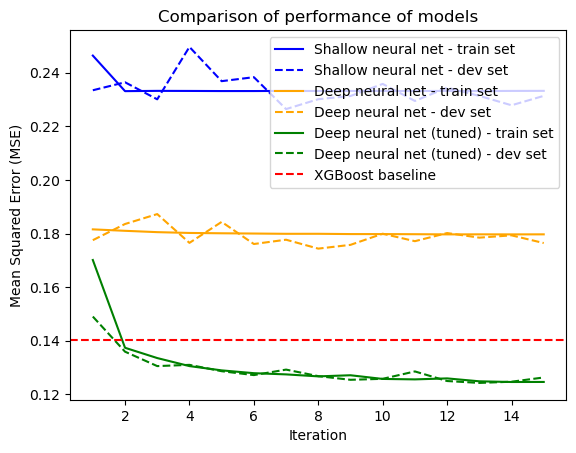

In [39]:
nn_dict = {
    'Shallow neural net': single_nn,
    'Deep neural net': deep_nn,
    'Deep neural net (tuned)': deep_nn_t
}
baseline_dict = {
    # 'Random Forest': rfr_mse,
    'XGBoost baseline': 0.1403
}

generate_plot(nn_dict, baseline_dict, cut_off_epoch=15, save=True, name='model_mse_2402023.png')

### Calculating marginal valuation of environmental attributes

Once we have a model with environmental attributes as features and log of house price as the target variable, we can begin to construct the marginal willingness to pay for environmental attributes, and therefore get a proxy for their value.

The partial derivative of `ln_price` w.r.t an input variable can be evaluated during the backwards propagation stage of the model fitting. By evaluating this derivative at a variety of samples, we can plot a valulation curve for the change in $ln(price)$ for a change in the input feature by 1 standard deviation.

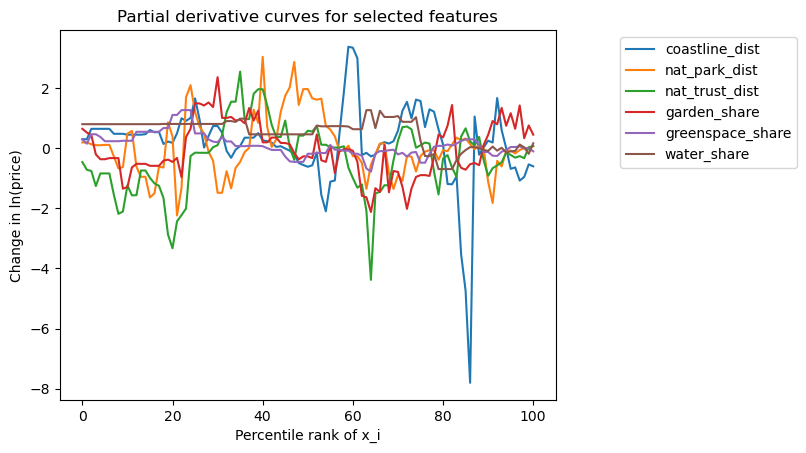

In [16]:
# extract the gradients from the model
if tune_nn:
    model_to_plot = deep_nn_t
else:
    model_to_plot = deep_nn

gradients, synthetic_data = calc_partial_grad(
    model_to_plot,
    x,
    derivative_index,
    norm_index,
    pop_mean,
    pop_std,
    100)

plot_partial_grads(gradients, np.arange(101), save=True, name='partial_grads_back_prop_240223.png')

4/4 [==============================] - 0s 636us/step


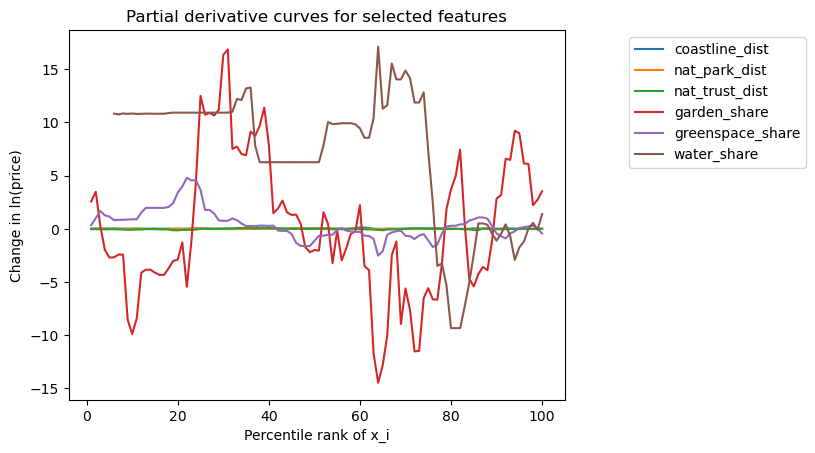

In [18]:
gradients, synthetic_data = calc_partial_grad_temp(
    model_to_plot,
    x,
    derivative_index,
    norm_index,
    pop_mean,
    pop_std,
    100
)

plot_partial_grads(gradients, np.arange(100)+1, save=True, name='partial_grads_approx_240223.png')

### Saving models

Here we save the pre-trained models so they can be loaded and used.

In [19]:
model_dir = cwd / "outputs" / "models"

# save models as tensor objects
if tune_nn:
    deep_nn_t.save(model_dir / "deep_nn_tuning.keras")
deep_nn.save(model_dir / "deep_nn.keras")
    
single_nn.save(model_dir / "single_nn.keras")

# save models as joblib files
joblib.dump(xgb_model, model_dir / "xgboost.joblib")

['/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/outputs/models/xgboost.joblib']

In [18]:
# to reload models
if tune_nn:
    deep_nn_t = tf.keras.models.load_model(model_dir / "deep_nn_tuning.keras")
deep_nn = tf.keras.models.load_model(model_dir / "deep_nn.keras")
    
single_nn = tf.keras.models.load_model(model_dir / "single_nn.keras")

xgb_model = joblib.load(model_dir / "xgboost.joblib")